In [8]:
!pip install -e ../../geoai

Obtaining file:///Users/dikaizm/Documents/PROGRAMMING/machine-learning/research-crop-mapping-thesis/geoai
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for geoai-py (pyproject.toml) ... done
  Created wheel for geoai-py: filename=geoai_py-0.12.0-0.editable-py2.py3-none-any.whl size=7701 sha256=7474f2ecb3ca10acdd3d9f6daa02b7720a80297cdfad75a9b608100d709919f9
  Stored in directory: /private/var/folders/hb/b1p7kpgj4s759vkptsfqzxzw0000gn/T/pip-ephem-wheel-cache-t7z_j4_n/wheels/90/da/b6/56765eee06e66ad757c102a2ea5ba089cd6eafd5b07a0af024
Successfully built geoai-py
  Attempting uninstall: geoai-py
    Found existing installation: geoai-py 0.12.0
    Uninstalling geoai-py-0.12.0:
      Successfully uninstalled geoai-py-0.12.0

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip 

### Reload Library

In [1]:
import geoai
import geoai.label_utils
import geoai.utils

import sys
sys.path.append("../")

import importlib
importlib.reload(geoai)
importlib.reload(geoai.label_utils)
importlib.reload(geoai.utils)

<module 'geoai.utils' from '/Users/dikaizm/Documents/PROGRAMMING/machine-learning/research-crop-mapping-thesis/geoai/geoai/utils.py'>

In [15]:
data_dir = "../data"

train_path = f"{data_dir}/raw/images/S2H_2023_2023_06_30_nodata.tif"
label_path = f"{data_dir}/raw/cdl/2023_30m_cdls_10m_remap.tif"
label_path_vector = f"{data_dir}/raw/labels/2024_30m_cdls_resampled.geojson"

In [5]:
geoai.get_raster_info(train_path)

{'driver': 'GTiff',
 'width': 7217,
 'height': 5495,
 'count': 9,
 'dtype': 'float64',
 'crs': 'EPSG:4326',
 'transform': Affine(8.983152847443538e-05, 0.0, -122.075297894,
        0.0, -8.983152848043673e-05, 39.176787182),
 'bounds': BoundingBox(left=-122.075297894, bottom=38.683162933, right=-121.426983753, top=39.176787182),
 'resolution': (8.983152847443538e-05, 8.983152848043673e-05),
 'nodata': -9999.0,
 'band_stats': [{'band': 1,
   'min': 0.0,
   'max': 19944.0,
   'mean': 639.1254983615107,
   'std': 353.2116881281851},
  {'band': 2,
   'min': 0.0,
   'max': 18488.0,
   'mean': 932.0045798903543,
   'std': 384.5503780499244},
  {'band': 3,
   'min': 0.0,
   'max': 17416.0,
   'mean': 1027.0463133696933,
   'std': 542.0625909614504},
  {'band': 4,
   'min': 0.0,
   'max': 17033.0,
   'mean': 1411.10579038535,
   'std': 489.2619091145002},
  {'band': 5,
   'min': 0.0,
   'max': 16769.0,
   'mean': 2124.313831323854,
   'std': 851.9892474576448},
  {'band': 6,
   'min': 0.0,
   

In [9]:
# geoai.view_raster_with_labels(train_path, label_path)

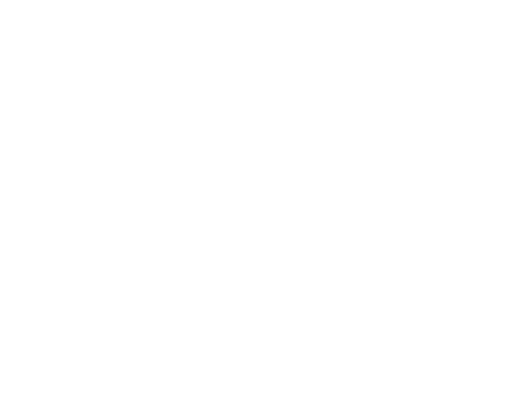

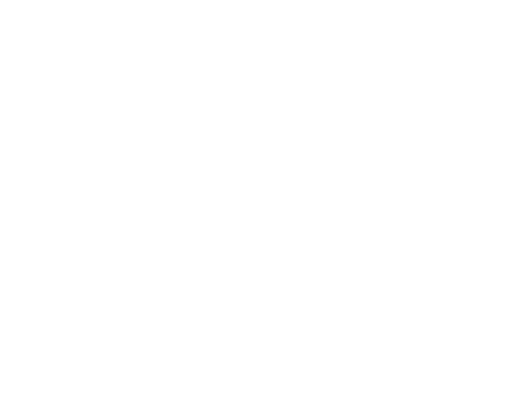

In [55]:
geoai.view_image(train_path)

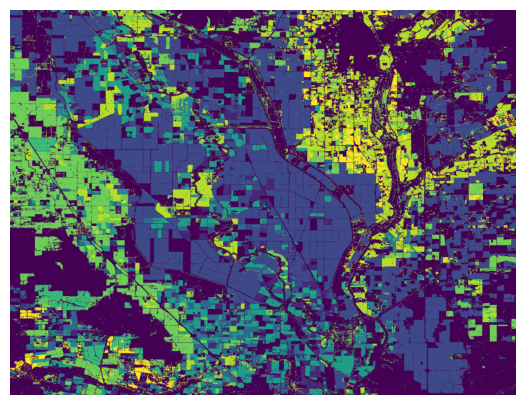

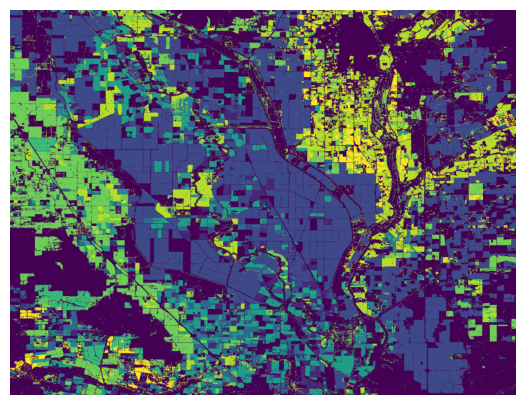

In [39]:
geoai.view_image(label_path)

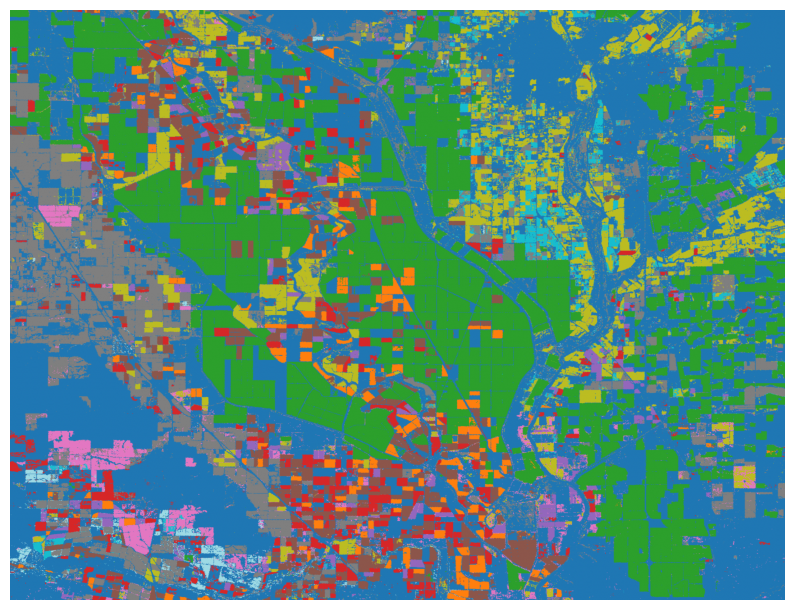

In [47]:
import rasterio
import matplotlib.pyplot as plt

# Open Sentinel-2
with rasterio.open(train_path) as src:
    s2 = src.read([3,2,1])  # RGB bands
    s2 = s2.transpose(1,2,0)  # reshape for plotting

# Open CDL
with rasterio.open(label_path) as src:
    cdl = src.read(1)

plt.figure(figsize=(10,10))
plt.imshow(s2 / s2.max())  # normalize Sentinel-2 RGB
plt.imshow(cdl, alpha=1, cmap="tab20")  # overlay CDL
plt.axis("off")
plt.show()

## Train on single image

In [40]:
import os

out_name = "crop_mapping"
data_folder = f"../data/processed/{out_name}"

model_folder = f"../models/{out_name}"
os.makedirs(model_folder, exist_ok=True)

# this function will create folders (annotations, images, labels)
tiles = geoai.export_geotiff_tiles(
    in_raster=train_path,
    out_folder=data_folder,
    in_class_data=label_path,
    tile_size=256,
    stride=256,
    buffer_radius=0,
)

Detected in_class_data as raster: ../data/raw/cdl/2023_30m_cdls_10m_remap.tif
Raster CRS: EPSG:4326
Raster dimensions: 7217 x 5495

Raster info for ../data/raw/images/S2H_2023_2023_06_30_nodata.tif:
  CRS: EPSG:4326
  Dimensions: 7217 x 5495
  Resolution: (8.983152841195215e-05, 8.983152841195215e-05)
  Bands: 9
  Bounds: BoundingBox(left=-122.0752978940246, bottom=38.68316293322643, right=-121.42698375347554, top=39.1767871818501)
Found 10 unique classes in raster: [ 1  2  3  4  5  6  7  8  9 10]


Generated: 638, With features: 634: 100%|██████████| 638/638 [00:06<00:00, 97.09it/s] 



------- Export Summary -------
Total tiles exported: 638
Tiles with features: 634 (99.4%)
Average feature pixels per tile: 74868.0
Output saved to: ../data/processed/crop_mapping

------- Georeference Verification -------


In [57]:
# Train U-Net model
geoai.train_segmentation_model(
    images_dir=f"{data_folder}/images",
    labels_dir=f"{data_folder}/labels",
    output_dir=f"{model_folder}/unet_models",
    architecture="unet",
    encoder_name="resnet34",
    encoder_weights="imagenet",
    num_channels=9,
    num_classes=11, # background and 10 crop classes
    batch_size=8,
    num_epochs=50,
    learning_rate=0.001,
    val_split=0.2,
    verbose=True,
)

Using device: mps
Found 638 image files and 638 label files
Training on 510 images, validating on 128 images
Checking image sizes for compatibility...
All sampled images have the same size: (256, 256)
No resizing needed.
Testing data loader...
Data loader test passed.
Starting training with unet + resnet34
Model parameters: 24,456,635
Epoch: 1, Batch: 1/64, Loss: 2.6001, Time: 3.70s
Epoch: 1, Batch: 11/64, Loss: 1.9770, Time: 3.32s
Epoch: 1, Batch: 21/64, Loss: 1.7249, Time: 1.59s
Epoch: 1, Batch: 31/64, Loss: 1.8284, Time: 1.64s
Epoch: 1, Batch: 41/64, Loss: 1.5498, Time: 1.60s
Epoch: 1, Batch: 51/64, Loss: 1.7223, Time: 1.59s
Epoch: 1, Batch: 61/64, Loss: 1.6704, Time: 1.60s
Epoch 1/50: Train Loss: 1.8826, Val Loss: 1.7573, Val IoU: 0.0698, Val Dice: 0.0870
Saving best model with IoU: 0.0698
Epoch: 2, Batch: 1/64, Loss: 1.3337, Time: 0.30s
Epoch: 2, Batch: 11/64, Loss: 1.9284, Time: 1.73s
Epoch: 2, Batch: 21/64, Loss: 1.5858, Time: 1.66s
Epoch: 2, Batch: 31/64, Loss: 1.7567, Time: 1.

## Train on multi images

### Build dataset

In [29]:
out_name = "crop_mapping_multi_images"

data_folder = f"../data/processed/{out_name}"
model_folder = f"../models/{out_name}"
os.makedirs(model_folder, exist_ok=True)

source_folder = "../data/raw"

geoai.export_geotiff_tiles_batch(
    images_folder=f"{source_folder}/images",
    masks_folder=f"{source_folder}/labels",
    output_folder=data_folder,
    tile_size=256,
    stride=256,
    buffer_radius=0,
)

Found 3 image files and 3 mask files to process
Processing batch from ../data/raw/images and ../data/raw/labels
Output folder: ../data/processed/crop_mapping_multi_images
------------------------------------------------------------


Processing image pairs:   0%|          | 0/3 [00:00<?, ?it/s]


Processing: S2H_2023_2023_05_01_nodata
  Image: S2H_2023_2023_05_01_nodata.tif
  Mask: cdl_2023_05_01.tif


Processing image pairs:  33%|███▎      | 1/3 [00:05<00:10,  5.11s/it]


Processing: S2H_2023_2023_05_31_nodata
  Image: S2H_2023_2023_05_31_nodata.tif
  Mask: cdl_2023_05_31.tif


Processing image pairs:  67%|██████▋   | 2/3 [00:10<00:05,  5.27s/it]


Processing: S2H_2023_2023_06_30_nodata
  Image: S2H_2023_2023_06_30_nodata.tif
  Mask: cdl_2023_06_30.tif


Processing image pairs: 100%|██████████| 3/3 [00:15<00:00,  5.08s/it]


BATCH PROCESSING SUMMARY
Total image pairs found: 3
Successfully processed: 3
Failed to process: 0
Total tiles generated: 1914
Tiles with features: 1902
Feature percentage: 99.4%
Output saved to: ../data/processed/crop_mapping_multi_images
  Images: ../data/processed/crop_mapping_multi_images/images
  Masks: ../data/processed/crop_mapping_multi_images/masks


{'total_image_pairs': 3,
 'processed_pairs': 3,
 'total_tiles': 1914,
 'tiles_with_features': 1902,
 'errors': 0,
 'processed_files': [{'image': '../data/raw/images/S2H_2023_2023_05_01_nodata.tif',
   'mask': '../data/raw/labels/cdl_2023_05_01.tif',
   'base_name': 'S2H_2023_2023_05_01_nodata',
   'tiles_generated': 638,
   'tiles_with_features': 634},
  {'image': '../data/raw/images/S2H_2023_2023_05_31_nodata.tif',
   'mask': '../data/raw/labels/cdl_2023_05_31.tif',
   'base_name': 'S2H_2023_2023_05_31_nodata',
   'tiles_generated': 638,
   'tiles_with_features': 634},
  {'image': '../data/raw/images/S2H_2023_2023_06_30_nodata.tif',
   'mask': '../data/raw/labels/cdl_2023_06_30.tif',
   'base_name': 'S2H_2023_2023_06_30_nodata',
   'tiles_generated': 638,
   'tiles_with_features': 634}],
 'failed_files': []}

In [32]:
import os
import numpy as np
import rasterio
from collections import Counter

mask_dir = f"{data_folder}/masks"

counter = Counter()
for fname in os.listdir(mask_dir):
    if fname.endswith(".tif"):
        with rasterio.open(os.path.join(mask_dir, fname)) as src:
            arr = src.read(1)
            vals, counts = np.unique(arr, return_counts=True)
            counter.update(dict(zip(vals, counts)))

print("Pixel counts per class:", counter)

# Convert to numpy array
classes = sorted(counter.keys())
freqs = np.array([counter[c] for c in classes], dtype=np.float64)

# Normalize to relative frequencies
freqs = freqs / freqs.sum()
print("Relative frequencies:", freqs)

Pixel counts per class: Counter({np.uint8(0): np.int64(54236421), np.uint8(2): np.int64(28521858), np.uint8(7): np.int64(13596753), np.uint8(8): np.int64(8692017), np.uint8(5): np.int64(6713898), np.uint8(3): np.int64(3998142), np.uint8(1): np.int64(2854200), np.uint8(6): np.int64(2217282), np.uint8(9): np.int64(2037171), np.uint8(4): np.int64(1824519), np.uint8(10): np.int64(743643)})
Relative frequencies: [0.43238355 0.02275425 0.22738193 0.03187398 0.01454543 0.05352453
 0.01767661 0.10839602 0.06929449 0.01624073 0.00592847]


In [33]:
import torch
import torch.nn as nn

weights = 1.0 / (freqs + 1e-6)
weights = weights / weights.sum() * len(classes)  # normalize to number of classes

class_weights = torch.tensor(weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights)

### Train U-Net

In [34]:
# Train U-Net model
geoai.train_segmentation_model(
    images_dir=f"{data_folder}/images",
    labels_dir=f"{data_folder}/masks",
    output_dir=f"{model_folder}/unet_models",
    architecture="unet",
    encoder_name="resnet34",
    encoder_weights="imagenet",
    criterion=criterion,
    num_channels=9,
    num_classes=11,
    batch_size=8,
    num_epochs=10,
    learning_rate=0.001,
    val_split=0.2,
    verbose=True,
)

Using device: mps
Found 1914 image files and 1914 label files
Training on 1531 images, validating on 383 images
Checking image sizes for compatibility...
All sampled images have the same size: (256, 256)
No resizing needed.
Testing data loader...
Data loader test passed.
Starting training with unet + resnet34
Model parameters: 24,456,635
Epoch: 1, Batch: 1/192, Loss: 2.7010, Time: 1.60s
Epoch: 1, Batch: 11/192, Loss: 1.9115, Time: 2.33s
Epoch: 1, Batch: 21/192, Loss: 1.8408, Time: 1.66s
Epoch: 1, Batch: 31/192, Loss: 1.8098, Time: 1.77s
Epoch: 1, Batch: 41/192, Loss: 1.6158, Time: 1.64s
Epoch: 1, Batch: 51/192, Loss: 2.0059, Time: 1.77s
Epoch: 1, Batch: 61/192, Loss: 1.5964, Time: 1.64s
Epoch: 1, Batch: 71/192, Loss: 1.8014, Time: 1.60s
Epoch: 1, Batch: 81/192, Loss: 1.9921, Time: 1.64s
Epoch: 1, Batch: 91/192, Loss: 1.4523, Time: 1.63s
Epoch: 1, Batch: 101/192, Loss: 1.7244, Time: 1.61s
Epoch: 1, Batch: 111/192, Loss: 1.9933, Time: 1.66s
Epoch: 1, Batch: 121/192, Loss: 1.4519, Time: 1

In [31]:
# Train U-Net model
geoai.train_segmentation_model(
    images_dir=f"{data_folder}/images",
    labels_dir=f"{data_folder}/masks",
    output_dir=f"{model_folder}/deeplabv3plus_models",
    architecture="deeplabv3plus",
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    num_channels=9,
    num_classes=11,
    batch_size=8,
    num_epochs=10,
    learning_rate=0.001,
    val_split=0.2,
    verbose=True,
)

Using device: mps
Found 1914 image files and 1914 label files
Training on 1531 images, validating on 383 images
Checking image sizes for compatibility...
All sampled images have the same size: (256, 256)
No resizing needed.
Testing data loader...
Data loader test passed.


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Starting training with deeplabv3plus + mobilenet_v2
Model parameters: 4,382,811
Epoch: 1, Batch: 1/192, Loss: 2.3987, Time: 2.83s
Epoch: 1, Batch: 11/192, Loss: 2.4055, Time: 1.39s
Epoch: 1, Batch: 21/192, Loss: 2.3955, Time: 1.25s
Epoch: 1, Batch: 31/192, Loss: 2.3753, Time: 1.26s
Epoch: 1, Batch: 41/192, Loss: 2.3835, Time: 1.32s
Epoch: 1, Batch: 51/192, Loss: 2.3700, Time: 1.98s
Epoch: 1, Batch: 61/192, Loss: 2.3606, Time: 1.34s
Epoch: 1, Batch: 71/192, Loss: 2.3544, Time: 1.34s
Epoch: 1, Batch: 81/192, Loss: 2.3467, Time: 1.31s
Epoch: 1, Batch: 91/192, Loss: 2.3389, Time: 1.47s
Epoch: 1, Batch: 101/192, Loss: 2.3132, Time: 1.38s
Epoch: 1, Batch: 111/192, Loss: 2.3155, Time: 1.36s
Epoch: 1, Batch: 121/192, Loss: 2.3132, Time: 1.33s
Epoch: 1, Batch: 131/192, Loss: 2.3176, Time: 1.41s
Epoch: 1, Batch: 141/192, Loss: 2.3074, Time: 1.29s
Epoch: 1, Batch: 151/192, Loss: 2.2907, Time: 1.39s
Epoch: 1, Batch: 161/192, Loss: 2.2698, Time: 1.31s
Epoch: 1, Batch: 171/192, Loss: 2.2832, Time: 1

## Train single image with subset bands

### Create subset

In [97]:
import rasterio
from rasterio.enums import Resampling
import numpy as np

s2_path = "../data/raw/images/S2H_2023_2023_06_30_nodata.tif"

subset = [1,2,3,7]      # B2,B3,B4,B8 (4-band)

out_path = "../data/raw/images_subset/S2H_2023_2023_06_30_nodata_subset.tif"

with rasterio.open(s2_path) as src:
    profile = src.profile.copy()
    profile.update(count=len(subset), dtype='float32')
    with rasterio.open(out_path, "w", **profile) as dst:
        for i, b in enumerate(subset, start=1):
            dst.write(src.read(b).astype("float32"), i)

print("Saved:", out_path)

Saved: ../data/raw/images_subset/S2H_2023_2023_06_30_nodata_subset.tif


In [98]:
geoai.get_raster_info("../data/raw/images_subset/S2H_2023_2023_06_30_nodata_subset.tif")

{'driver': 'GTiff',
 'width': 7217,
 'height': 5495,
 'count': 4,
 'dtype': 'float32',
 'crs': 'EPSG:4326',
 'transform': Affine(8.983152847443538e-05, 0.0, -122.075297894,
        0.0, -8.983152848043673e-05, 39.176787182),
 'bounds': BoundingBox(left=-122.075297894, bottom=38.683162933, right=-121.426983753, top=39.176787182),
 'resolution': (8.983152847443538e-05, 8.983152848043673e-05),
 'nodata': 0.0,
 'band_stats': [{'band': 1,
   'min': 19.0,
   'max': 18568.0,
   'mean': 645.5805368586872,
   'std': 399.65862936801346},
  {'band': 2,
   'min': 12.0,
   'max': 17496.0,
   'mean': 959.2787855692143,
   'std': 474.40512458907415},
  {'band': 3,
   'min': 1.0,
   'max': 16712.0,
   'mean': 1054.438970479311,
   'std': 771.6628431546216},
  {'band': 4,
   'min': 0.5,
   'max': 15864.0,
   'mean': 3296.473433411588,
   'std': 920.2911647891369}]}

In [86]:
geoai.get_raster_info(label_path)

{'driver': 'GTiff',
 'width': 7217,
 'height': 5495,
 'count': 1,
 'dtype': 'uint8',
 'crs': 'EPSG:4326',
 'transform': Affine(8.983152847443538e-05, 0.0, -122.075297894,
        0.0, -8.983152848043673e-05, 39.176787182),
 'bounds': BoundingBox(left=-122.075297894, bottom=38.683162933, right=-121.426983753, top=39.176787182),
 'resolution': (8.983152847443538e-05, 8.983152848043673e-05),
 'nodata': 255.0,
 'band_stats': [{'band': 1,
   'min': 0.0,
   'max': 10.0,
   'mean': 2.5702528266151488,
   'std': 2.954164840840326}]}

### Build dataset [stride 128]

In [2]:
import os

image_path = "../data/raw/images_subset/S2H_2023_2023_06_30_nodata_subset.tif"
label_path = "../data/raw/cdl/2023_30m_cdls_10m_remap.tif"

out_name = "crop_mapping_subset_2"
data_folder = f"../data/processed/{out_name}"

model_folder = f"../models/{out_name}"
os.makedirs(model_folder, exist_ok=True)

# # this function will create folders (annotations, images, labels)
# tiles = geoai.export_geotiff_tiles(
#     in_raster=image_path,
#     out_folder=data_folder,
#     in_class_data=label_path,
#     tile_size=256,
#     stride=128,
#     buffer_radius=0,
#     skip_empty_tiles=True,
# )

### Train DeepLabV3+

In [5]:
import torch
from geoai import losses

device = "cuda" if torch.cuda.is_available() else "mps"
print("Using device:", device)

criterion = losses.DECBLoss(
    num_classes=11,
    beta=0.9999,          # smoothing factor (as in paper)
    loss_type="ce",       # or "focal"
    gamma=2.0,            # focal gamma
    ignore_index=0,
    device=device
)

Using device: mps


In [6]:
# Train U-Net model
geoai.train_segmentation_model(
    images_dir=f"{data_folder}/images",
    labels_dir=f"{data_folder}/labels",
    output_dir=f"{model_folder}/deeplabv3plus_models",
    architecture="deeplabv3plus",
    encoder_name="efficientnet-b4",
    encoder_weights=None,
    num_channels=4,
    num_classes=11, # background and 10 crop classes
    batch_size=8,
    num_epochs=100,
    learning_rate=0.001,
    val_split=0.2,
    criterion=criterion,
    verbose=True
)

Using device: mps
Found 2345 image files and 2345 label files
Training on 1876 images, validating on 469 images
Checking image sizes for compatibility...
All sampled images have the same size: (256, 256)
No resizing needed.
Testing data loader...
Data loader test passed.
Starting training with deeplabv3plus + efficientnet-b4
Model parameters: 18,619,219
Epoch: 1, Batch: 1/234, Loss: 2.4060, Time: 1.50s
Epoch: 1, Batch: 11/234, Loss: 1.7646, Time: 2.98s
Epoch: 1, Batch: 21/234, Loss: 1.6630, Time: 2.98s
Epoch: 1, Batch: 31/234, Loss: 1.4963, Time: 2.96s
Epoch: 1, Batch: 41/234, Loss: 1.3328, Time: 2.99s
Epoch: 1, Batch: 51/234, Loss: 1.3923, Time: 2.97s
Epoch: 1, Batch: 61/234, Loss: 1.6279, Time: 2.95s
Epoch: 1, Batch: 71/234, Loss: 1.2847, Time: 2.94s
Epoch: 1, Batch: 81/234, Loss: 1.6287, Time: 2.96s
Epoch: 1, Batch: 91/234, Loss: 1.3021, Time: 2.94s
Epoch: 1, Batch: 101/234, Loss: 1.5398, Time: 2.95s
Epoch: 1, Batch: 111/234, Loss: 1.2592, Time: 2.96s
Epoch: 1, Batch: 121/234, Loss:

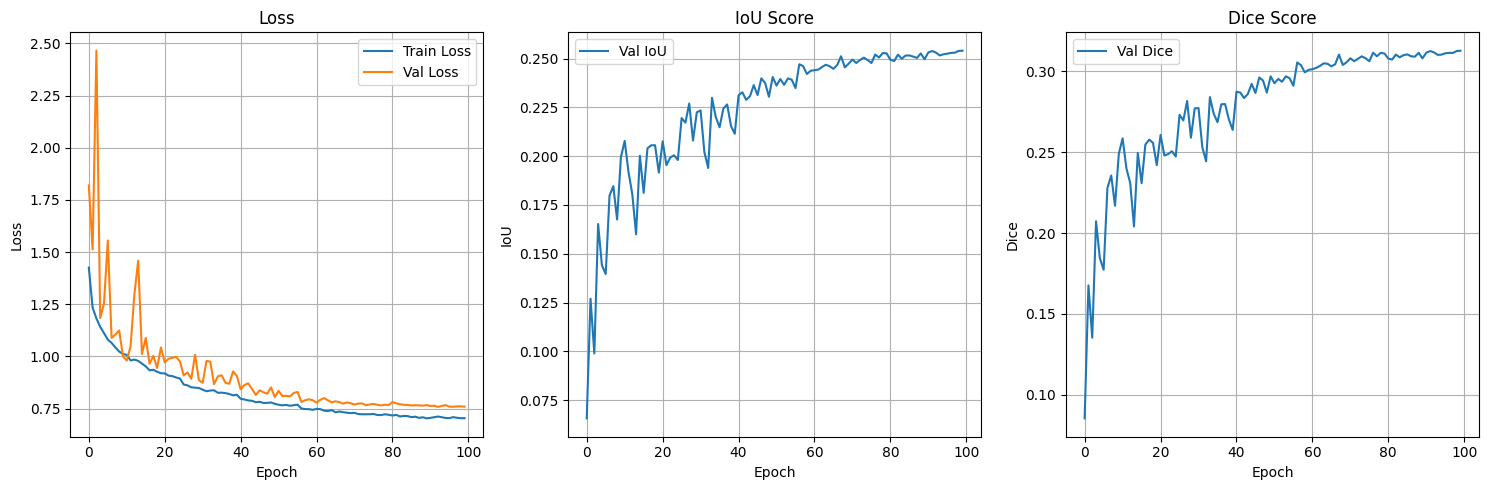

Best IoU: 0.2540
Final IoU: 0.2540
Best Dice: 0.3128
Final Dice: 0.3128


In [8]:
geoai.plot_performance_metrics(
    history_path=f"{model_folder}/deeplabv3plus_models/training_history.pth",
    figsize=(15, 5),
    verbose=True,
)

#### Run inference

In [ ]:
# Define paths
model_path = f"{model_folder}/deeplabv3plus_models/best_model.pth"
test_raster_path = "../data/raw/images_subset/S2H_2023_2023_06_30_nodata_subset.tif"
predicted_path = f"../data/predicted/{out_name}/S2H_2023_2023_06_30_predicted.tif"

# Run semantic segmentation inference
geoai.semantic_segmentation(
    input_path=test_raster_path,
    output_path=predicted_path,
    model_path=model_path,
    architecture="deeplabv3plus",
    encoder_name="efficientnet-b4",
    num_channels=4,
    num_classes=11,
    window_size=256,
    overlap=128,
    batch_size=4,
)

In [4]:
geoai.get_raster_info(predicted_path)

{'driver': 'GTiff',
 'width': 7217,
 'height': 5495,
 'count': 1,
 'dtype': 'uint8',
 'crs': 'EPSG:4326',
 'transform': Affine(8.983152847443538e-05, 0.0, -122.075297894,
        0.0, -8.983152848043673e-05, 39.176787182),
 'bounds': BoundingBox(left=-122.075297894, bottom=38.683162933, right=-121.426983753, top=39.176787182),
 'resolution': (8.983152847443538e-05, 8.983152848043673e-05),
 'nodata': 0.0,
 'band_stats': [{'band': 1,
   'min': 1.0,
   'max': 10.0,
   'mean': 4.25032324916253,
   'std': 2.5636822730834217}]}

#### Remap prediction class code

In [42]:
from geoai import label_utils

# Map them into compact range
mapping = {
    0: 0,   # Background
    1: 1,   # Corn
    3: 2,   # Rice
    24: 3,  # Winter Wheat
    36: 4,  # Alfalfa
    54: 5,  # Tomatoes
    69: 6,  # Grapes
    75: 7,  # Almonds
    76: 8,  # Walnuts
    210: 9, # Prunes
    211: 10 # Olives
}

# Remap back to original class codes
label_utils.remap_back_raster(
    in_path=predicted_path,
    out_path=predicted_path.replace(".tif", "_remap.tif"),
    mapping=mapping
)

Unique compact values in prediction: [ 0  1  2  3  4  5  6  7  8  9 10]
Saved restored raster to ../data/predicted/crop_mapping_subset_2/S2H_2023_2023_06_30_predicted_remap.tif
Unique values (original CDL): [  0   1   3  24  36  54  69  75  76 210 211]


In [15]:
geoai.get_raster_info(predicted_path.replace(".tif", "_remap.tif"))

{'driver': 'GTiff',
 'width': 7217,
 'height': 5495,
 'count': 1,
 'dtype': 'uint16',
 'crs': 'EPSG:4326',
 'transform': Affine(8.983152847443538e-05, 0.0, -122.075297894,
        0.0, -8.983152848043673e-05, 39.176787182),
 'bounds': BoundingBox(left=-122.075297894, bottom=38.683162933, right=-121.426983753, top=39.176787182),
 'resolution': (8.983152847443538e-05, 8.983152848043673e-05),
 'nodata': 255.0,
 'band_stats': [{'band': 1,
   'min': 0.0,
   'max': 211.0,
   'mean': 21.595908558336443,
   'std': 38.06274970163499}]}

#### Visualize prediction

In [5]:
from utils.constants import USDA_CDL_COLORS

geoai.view_raster_with_labels(
    raster_image=image_path,
    label_raster=predicted_path,
    class_mapping={
        # 0: "Background",
        1: "Corn",
        3: "Rice",
        24: "Winter Wheat",
        36: "Alfalfa",
        54: "Tomatoes",
        69: "Grapes",
        75: "Almonds",
        76: "Walnuts",
        210: "Prunes",
        211: "Olives"
    },
    class_colors={
        # 0: USDA_CDL_COLORS.get(0),
        1: USDA_CDL_COLORS.get(1),
        3: USDA_CDL_COLORS.get(3),
        24: USDA_CDL_COLORS.get(24),
        36: USDA_CDL_COLORS.get(36),
        54: USDA_CDL_COLORS.get(54),
        69: USDA_CDL_COLORS.get(69),
        75: USDA_CDL_COLORS.get(75),
        76: USDA_CDL_COLORS.get(76),
        210: USDA_CDL_COLORS.get(210),
        211: USDA_CDL_COLORS.get(211)
    },
    raster_indexes=(1, 2, 3),
    raster_layer_name="Satellite",
    label_layer_name="Labels",
    legend_title="Crop Classes",
    opacity=0.5,
)

Map(center=[38.929975, -121.751141], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

---

### Build dataset [stride 80]

In [2]:
import os

image_path = "../data/raw/images_subset/S2H_2023_2023_06_30_nodata_subset.tif"
label_path = "../data/raw/cdl/2023_30m_cdls_10m_remap.tif"

out_name = "crop_mapping_subset_3"
data_folder = f"../data/processed/{out_name}"

model_folder = f"../models/{out_name}"
os.makedirs(model_folder, exist_ok=True)

# # this function will create folders (annotations, images, labels)
# tiles = geoai.export_geotiff_tiles(
#     in_raster=image_path,
#     out_folder=data_folder,
#     in_class_data=label_path,
#     tile_size=256,
#     stride=80,
#     buffer_radius=0,
#     skip_empty_tiles=True,
# )

### Train DeepLabV3+

In [57]:
import torch
from geoai import losses

device = "cuda" if torch.cuda.is_available() else "mps"
print("Using device:", device)

criterion = losses.DECBLoss(
    num_classes=11,
    beta=0.9999,          # smoothing factor (as in paper)
    loss_type="ce",       # or "focal"
    gamma=2.0,            # focal gamma
    ignore_index=0,
    device=device
)

Using device: mps


In [ ]:
geoai.train_segmentation_model(
    images_dir=f"{data_folder}/images",
    labels_dir=f"{data_folder}/labels",
    output_dir=f"{model_folder}/deeplabv3plus_models",
    architecture="deeplabv3plus",
    encoder_name="efficientnet-b5",
    encoder_weights=None,
    num_channels=4,
    num_classes=11, # background and 10 crop classes
    batch_size=8,
    num_epochs=50,
    learning_rate=0.001,
    val_split=0.2,
    criterion=criterion,
    verbose=True
)

Using device: mps
Found 5948 image files and 5948 label files
Training on 4758 images, validating on 1190 images
Checking image sizes for compatibility...
All sampled images have the same size: (256, 256)
No resizing needed.
Testing data loader...
Data loader test passed.
Starting training with deeplabv3plus + efficientnet-b5
Model parameters: 29,495,419
Epoch: 1, Batch: 1/594, Loss: 2.4528, Time: 0.77s
Epoch: 1, Batch: 11/594, Loss: 1.8830, Time: 4.14s
Epoch: 1, Batch: 21/594, Loss: 1.4053, Time: 3.96s
Epoch: 1, Batch: 31/594, Loss: 1.5953, Time: 4.00s
Epoch: 1, Batch: 41/594, Loss: 1.2465, Time: 4.04s
Epoch: 1, Batch: 51/594, Loss: 1.5041, Time: 4.03s
Epoch: 1, Batch: 61/594, Loss: 1.2158, Time: 3.99s
Epoch: 1, Batch: 71/594, Loss: 1.5004, Time: 4.06s
Epoch: 1, Batch: 81/594, Loss: 1.8547, Time: 4.04s
Epoch: 1, Batch: 91/594, Loss: 1.2912, Time: 4.01s
Epoch: 1, Batch: 101/594, Loss: 1.7731, Time: 3.97s
Epoch: 1, Batch: 111/594, Loss: 1.2249, Time: 4.07s
Epoch: 1, Batch: 121/594, Loss

Generated: 2903, With features: 2903:  40%|████      | 2911/7252 [08:56<13:19,  5.43it/s] 


Epoch: 2, Batch: 351/594, Loss: 0.9801, Time: 10.52s
Epoch: 2, Batch: 361/594, Loss: 0.8577, Time: 4.01s
Epoch: 2, Batch: 371/594, Loss: 0.9150, Time: 4.01s
Epoch: 2, Batch: 381/594, Loss: 1.3420, Time: 3.96s
Epoch: 2, Batch: 391/594, Loss: 1.0041, Time: 3.97s
Epoch: 2, Batch: 401/594, Loss: 1.1261, Time: 3.97s
Epoch: 2, Batch: 411/594, Loss: 1.0815, Time: 4.05s
Epoch: 2, Batch: 421/594, Loss: 1.3399, Time: 4.12s
Epoch: 2, Batch: 431/594, Loss: 1.1644, Time: 4.15s
Epoch: 2, Batch: 441/594, Loss: 1.2137, Time: 4.14s
Epoch: 2, Batch: 451/594, Loss: 1.0847, Time: 4.12s
Epoch: 2, Batch: 461/594, Loss: 0.8853, Time: 4.18s
Epoch: 2, Batch: 471/594, Loss: 1.1341, Time: 4.19s
Epoch: 2, Batch: 481/594, Loss: 1.1614, Time: 4.20s
Epoch: 2, Batch: 491/594, Loss: 0.9276, Time: 4.49s
Epoch: 2, Batch: 501/594, Loss: 1.1080, Time: 4.18s
Epoch: 2, Batch: 511/594, Loss: 0.6542, Time: 4.12s
Epoch: 2, Batch: 521/594, Loss: 1.0216, Time: 4.12s
Epoch: 2, Batch: 531/594, Loss: 1.0711, Time: 4.26s
Epoch: 2, B

KeyboardInterrupt: 

In [ ]:
geoai.plot_performance_metrics(
    history_path=f"{model_folder}/deeplabv3plus_models/training_history.pth",
    figsize=(15, 5),
    verbose=True,
)

#### Run inference

In [ ]:
# Define paths
model_path = f"{model_folder}/deeplabv3plus_models/best_model.pth"
test_raster_path = "../data/raw/images_subset/S2H_2023_2023_06_30_nodata_subset.tif"
predicted_path = f"../data/predicted/{out_name}/S2H_2023_2023_06_30_predicted.tif"

# Run semantic segmentation inference
geoai.semantic_segmentation(
    input_path=test_raster_path,
    output_path=predicted_path,
    model_path=model_path,
    architecture="deeplabv3plus",
    encoder_name="efficientnet-b5",
    num_channels=4,
    num_classes=11,
    window_size=256,
    overlap=80,
    batch_size=8,
)

In [7]:
from geoai import label_utils

label_utils.get_unique_classes(predicted_path)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

#### Remap prediction class code

In [70]:
geoai.get_raster_info(predicted_path)

{'driver': 'GTiff',
 'width': 7217,
 'height': 5495,
 'count': 1,
 'dtype': 'uint8',
 'crs': 'EPSG:4326',
 'transform': Affine(8.983152847443538e-05, 0.0, -122.075297894,
        0.0, -8.983152848043673e-05, 39.176787182),
 'bounds': BoundingBox(left=-122.075297894, bottom=38.683162933, right=-121.426983753, top=39.176787182),
 'resolution': (8.983152847443538e-05, 8.983152848043673e-05),
 'nodata': 0.0,
 'band_stats': [{'band': 1,
   'min': 1.0,
   'max': 10.0,
   'mean': 4.297906660952185,
   'std': 2.571642344221063}]}

In [73]:
from geoai import label_utils

# Map them into compact range
mapping = {
    0: 0,   # Background
    1: 1,   # Corn
    3: 2,   # Rice
    24: 3,  # Winter Wheat
    36: 4,  # Alfalfa
    54: 5,  # Tomatoes
    69: 6,  # Grapes
    75: 7,  # Almonds
    76: 8,  # Walnuts
    210: 9, # Prunes
    211: 10 # Olives
}

# Remap back to original class codes
label_utils.remap_back_raster(
    in_path=predicted_path,
    out_path=predicted_path.replace(".tif", "_remap.tif"),
    mapping=mapping
)

Unique compact values in prediction: [ 0  1  2  3  4  5  6  7  8  9 10]
Saved restored raster to ../data/predicted/crop_mapping_subset_3/S2H_2023_2023_06_30_predicted_remap.tif
Unique values (original CDL): [  0   1   3  24  36  54  69  75  76 210 211]


#### Visualize prediction

In [74]:
geoai.get_raster_info(predicted_path.replace(".tif", "_remap.tif"))

{'driver': 'GTiff',
 'width': 7217,
 'height': 5495,
 'count': 1,
 'dtype': 'uint16',
 'crs': 'EPSG:4326',
 'transform': Affine(8.983152847443538e-05, 0.0, -122.075297894,
        0.0, -8.983152848043673e-05, 39.176787182),
 'bounds': BoundingBox(left=-122.075297894, bottom=38.683162933, right=-121.426983753, top=39.176787182),
 'resolution': (8.983152847443538e-05, 8.983152848043673e-05),
 'nodata': 255.0,
 'band_stats': [{'band': 1,
   'min': 0.0,
   'max': 211.0,
   'mean': 20.94951930174975,
   'std': 37.19268358106741}]}

In [25]:
import sys
sys.path.append("../")
from utils.constants import USDA_CDL_COLORS

geoai.view_raster_with_labels(
    raster_image=image_path,
    label_raster=predicted_path,
    class_mapping={
        # 0: "Background",
        1: "Corn",
        3: "Rice",
        24: "Winter Wheat",
        36: "Alfalfa",
        54: "Tomatoes",
        69: "Grapes",
        75: "Almonds",
        76: "Walnuts",
        210: "Prunes",
        211: "Olives"
    },
    class_colors={
        # 0: USDA_CDL_COLORS.get(0),
        1: USDA_CDL_COLORS.get(1),
        3: USDA_CDL_COLORS.get(3),
        24: USDA_CDL_COLORS.get(24),
        36: USDA_CDL_COLORS.get(36),
        54: USDA_CDL_COLORS.get(54),
        69: USDA_CDL_COLORS.get(69),
        75: USDA_CDL_COLORS.get(75),
        76: USDA_CDL_COLORS.get(76),
        210: USDA_CDL_COLORS.get(210),
        211: USDA_CDL_COLORS.get(211)
    },
    raster_indexes=(3, 2, 1),
    raster_layer_name="Satellite",
    label_layer_name="Labels",
    legend_title="Crop Classes",
    opacity=0.5,
)

Map(center=[38.929975, -121.751141], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

### Train DeepLabV3+ [oversampling]

#### Setup oversampling for DataLoader

In [3]:
import os
import numpy as np
import rasterio
import torch
from torch.utils.data import WeightedRandomSampler

def compute_tile_class(label_path):
    with rasterio.open(label_path) as src:
        mask = src.read(1)
    # exclude nodata
    unique, counts = np.unique(mask[mask != 255], return_counts=True)
    if len(unique) == 0:
        return None
    # return dominant class in the tile
    return unique[np.argmax(counts)]

# Compute class distribution
labels_dir = "../data/processed/crop_mapping_subset_3/labels"
tile_classes = []
for fname in os.listdir(labels_dir):
    if fname.endswith(".tif"):
        tile_class = compute_tile_class(os.path.join(labels_dir, fname))
        if tile_class is not None:
            tile_classes.append(tile_class)

# Count occurrences
class_counts = np.bincount(tile_classes)
class_weights = 1.0 / (class_counts + 1e-6)

# # Assign weights per sample
# sample_weights = [class_weights[c] for c in tile_classes]
# print(sample_weights)

# sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

#### Setup loss criterion

In [4]:
import segmentation_models_pytorch as smp
import torch

criterion = smp.losses.FocalLoss(
    mode="multiclass",   # 'binary', 'multiclass', or 'multilabel'
    gamma=2.0,           # focusing parameter
    alpha=None,          # can be class weights (Tensor of shape [C])
    ignore_index=255,    # mask out nodata
    reduction="mean"     # or "sum"
)

# criterion = smp.losses.FocalLoss(
#     mode="multiclass",
#     alpha=class_weights,   # balances minority vs majority crops
#     gamma=2.0,
#     ignore_index=255
# )

#### Train model

In [5]:
model_folder = f"../models/crop_mapping_subset_test_only"

geoai.train_segmentation_model(
    images_dir=f"{data_folder}/images",
    labels_dir=f"{data_folder}/labels",
    output_dir=f"{model_folder}/deeplabv3plus_models",
    architecture="deeplabv3plus",
    encoder_name="efficientnet-b0",
    encoder_weights=None,
    num_channels=4,
    num_classes=11, # background and 10 crop classes
    batch_size=8,
    num_epochs=10,
    learning_rate=0.001,
    val_split=0.2,
    # criterion=criterion,
    verbose=True,
    class_balanced=True,
    save_best_only=False,
    checkpoint_interval=5
)

Using device: mps
Found 5948 image files and 5948 label files
Training on 4758 images, validating on 1190 images
Checking image sizes for compatibility...
All sampled images have the same size: (256, 256)
No resizing needed.
Building class-balanced sampler (strategy='presence') ...
Class-balanced sampler ready. Non-empty classes: 11/11.
Using class balanced sampler
Testing data loader...
Data loader test passed.
Starting training with deeplabv3plus + efficientnet-b0
Model parameters: 4,910,327
Epoch: 1, Batch: 1/594, Loss: 2.4446, Time: 1.24s
Epoch: 1, Batch: 11/594, Loss: 1.7025, Time: 1.31s
Epoch: 1, Batch: 21/594, Loss: 1.3886, Time: 1.28s
Epoch: 1, Batch: 31/594, Loss: 1.3384, Time: 1.29s
Epoch: 1, Batch: 41/594, Loss: 1.6083, Time: 1.27s
Epoch: 1, Batch: 51/594, Loss: 1.2938, Time: 1.28s
Epoch: 1, Batch: 61/594, Loss: 1.7587, Time: 1.28s
Epoch: 1, Batch: 71/594, Loss: 1.5181, Time: 1.30s
Epoch: 1, Batch: 81/594, Loss: 1.2024, Time: 1.30s
Epoch: 1, Batch: 91/594, Loss: 1.5367, Time

#### Plot model performance

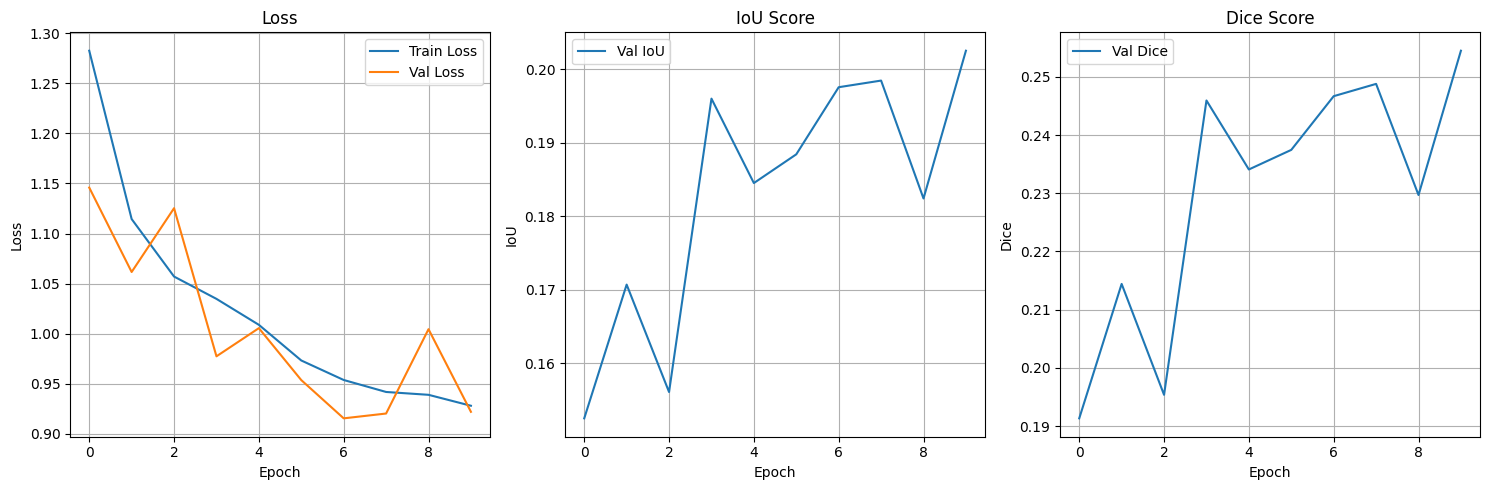

Best IoU: 0.2025
Final IoU: 0.2025
Best Dice: 0.2545
Final Dice: 0.2545


In [8]:
geoai.plot_performance_metrics(
    history_path=f"{model_folder}/deeplabv3plus_models/training_history.pth",
    figsize=(15, 5),
    verbose=True,
)

#### Run inference

In [7]:
# Define paths
model_path = f"{model_folder}/deeplabv3plus_models/best_model.pth"
test_raster_path = "../data/raw/images_subset/S2H_2023_2023_06_30_nodata_subset.tif"
predicted_path = f"../data/predicted/{out_name}/S2H_2023_2023_06_30_predicted.tif"

# Run semantic segmentation inference
geoai.semantic_segmentation(
    input_path=test_raster_path,
    output_path=predicted_path,
    model_path=model_path,
    architecture="deeplabv3plus",
    encoder_name="efficientnet-b3",
    num_channels=4,
    num_classes=11,
    window_size=256,
    overlap=80,
    batch_size=8,
)

Input file format: GeoTIFF (.tif)


RuntimeError: Error(s) in loading state_dict for DeepLabV3Plus:
	Missing key(s) in state_dict: "encoder._blocks.16._expand_conv.weight", "encoder._blocks.16._bn0.weight", "encoder._blocks.16._bn0.bias", "encoder._blocks.16._bn0.running_mean", "encoder._blocks.16._bn0.running_var", "encoder._blocks.16._depthwise_conv.weight", "encoder._blocks.16._bn1.weight", "encoder._blocks.16._bn1.bias", "encoder._blocks.16._bn1.running_mean", "encoder._blocks.16._bn1.running_var", "encoder._blocks.16._se_reduce.weight", "encoder._blocks.16._se_reduce.bias", "encoder._blocks.16._se_expand.weight", "encoder._blocks.16._se_expand.bias", "encoder._blocks.16._project_conv.weight", "encoder._blocks.16._bn2.weight", "encoder._blocks.16._bn2.bias", "encoder._blocks.16._bn2.running_mean", "encoder._blocks.16._bn2.running_var", "encoder._blocks.17._expand_conv.weight", "encoder._blocks.17._bn0.weight", "encoder._blocks.17._bn0.bias", "encoder._blocks.17._bn0.running_mean", "encoder._blocks.17._bn0.running_var", "encoder._blocks.17._depthwise_conv.weight", "encoder._blocks.17._bn1.weight", "encoder._blocks.17._bn1.bias", "encoder._blocks.17._bn1.running_mean", "encoder._blocks.17._bn1.running_var", "encoder._blocks.17._se_reduce.weight", "encoder._blocks.17._se_reduce.bias", "encoder._blocks.17._se_expand.weight", "encoder._blocks.17._se_expand.bias", "encoder._blocks.17._project_conv.weight", "encoder._blocks.17._bn2.weight", "encoder._blocks.17._bn2.bias", "encoder._blocks.17._bn2.running_mean", "encoder._blocks.17._bn2.running_var", "encoder._blocks.18._expand_conv.weight", "encoder._blocks.18._bn0.weight", "encoder._blocks.18._bn0.bias", "encoder._blocks.18._bn0.running_mean", "encoder._blocks.18._bn0.running_var", "encoder._blocks.18._depthwise_conv.weight", "encoder._blocks.18._bn1.weight", "encoder._blocks.18._bn1.bias", "encoder._blocks.18._bn1.running_mean", "encoder._blocks.18._bn1.running_var", "encoder._blocks.18._se_reduce.weight", "encoder._blocks.18._se_reduce.bias", "encoder._blocks.18._se_expand.weight", "encoder._blocks.18._se_expand.bias", "encoder._blocks.18._project_conv.weight", "encoder._blocks.18._bn2.weight", "encoder._blocks.18._bn2.bias", "encoder._blocks.18._bn2.running_mean", "encoder._blocks.18._bn2.running_var", "encoder._blocks.19._expand_conv.weight", "encoder._blocks.19._bn0.weight", "encoder._blocks.19._bn0.bias", "encoder._blocks.19._bn0.running_mean", "encoder._blocks.19._bn0.running_var", "encoder._blocks.19._depthwise_conv.weight", "encoder._blocks.19._bn1.weight", "encoder._blocks.19._bn1.bias", "encoder._blocks.19._bn1.running_mean", "encoder._blocks.19._bn1.running_var", "encoder._blocks.19._se_reduce.weight", "encoder._blocks.19._se_reduce.bias", "encoder._blocks.19._se_expand.weight", "encoder._blocks.19._se_expand.bias", "encoder._blocks.19._project_conv.weight", "encoder._blocks.19._bn2.weight", "encoder._blocks.19._bn2.bias", "encoder._blocks.19._bn2.running_mean", "encoder._blocks.19._bn2.running_var", "encoder._blocks.20._expand_conv.weight", "encoder._blocks.20._bn0.weight", "encoder._blocks.20._bn0.bias", "encoder._blocks.20._bn0.running_mean", "encoder._blocks.20._bn0.running_var", "encoder._blocks.20._depthwise_conv.weight", "encoder._blocks.20._bn1.weight", "encoder._blocks.20._bn1.bias", "encoder._blocks.20._bn1.running_mean", "encoder._blocks.20._bn1.running_var", "encoder._blocks.20._se_reduce.weight", "encoder._blocks.20._se_reduce.bias", "encoder._blocks.20._se_expand.weight", "encoder._blocks.20._se_expand.bias", "encoder._blocks.20._project_conv.weight", "encoder._blocks.20._bn2.weight", "encoder._blocks.20._bn2.bias", "encoder._blocks.20._bn2.running_mean", "encoder._blocks.20._bn2.running_var", "encoder._blocks.21._expand_conv.weight", "encoder._blocks.21._bn0.weight", "encoder._blocks.21._bn0.bias", "encoder._blocks.21._bn0.running_mean", "encoder._blocks.21._bn0.running_var", "encoder._blocks.21._depthwise_conv.weight", "encoder._blocks.21._bn1.weight", "encoder._blocks.21._bn1.bias", "encoder._blocks.21._bn1.running_mean", "encoder._blocks.21._bn1.running_var", "encoder._blocks.21._se_reduce.weight", "encoder._blocks.21._se_reduce.bias", "encoder._blocks.21._se_expand.weight", "encoder._blocks.21._se_expand.bias", "encoder._blocks.21._project_conv.weight", "encoder._blocks.21._bn2.weight", "encoder._blocks.21._bn2.bias", "encoder._blocks.21._bn2.running_mean", "encoder._blocks.21._bn2.running_var", "encoder._blocks.22._expand_conv.weight", "encoder._blocks.22._bn0.weight", "encoder._blocks.22._bn0.bias", "encoder._blocks.22._bn0.running_mean", "encoder._blocks.22._bn0.running_var", "encoder._blocks.22._depthwise_conv.weight", "encoder._blocks.22._bn1.weight", "encoder._blocks.22._bn1.bias", "encoder._blocks.22._bn1.running_mean", "encoder._blocks.22._bn1.running_var", "encoder._blocks.22._se_reduce.weight", "encoder._blocks.22._se_reduce.bias", "encoder._blocks.22._se_expand.weight", "encoder._blocks.22._se_expand.bias", "encoder._blocks.22._project_conv.weight", "encoder._blocks.22._bn2.weight", "encoder._blocks.22._bn2.bias", "encoder._blocks.22._bn2.running_mean", "encoder._blocks.22._bn2.running_var", "encoder._blocks.23._expand_conv.weight", "encoder._blocks.23._bn0.weight", "encoder._blocks.23._bn0.bias", "encoder._blocks.23._bn0.running_mean", "encoder._blocks.23._bn0.running_var", "encoder._blocks.23._depthwise_conv.weight", "encoder._blocks.23._bn1.weight", "encoder._blocks.23._bn1.bias", "encoder._blocks.23._bn1.running_mean", "encoder._blocks.23._bn1.running_var", "encoder._blocks.23._se_reduce.weight", "encoder._blocks.23._se_reduce.bias", "encoder._blocks.23._se_expand.weight", "encoder._blocks.23._se_expand.bias", "encoder._blocks.23._project_conv.weight", "encoder._blocks.23._bn2.weight", "encoder._blocks.23._bn2.bias", "encoder._blocks.23._bn2.running_mean", "encoder._blocks.23._bn2.running_var", "encoder._blocks.24._expand_conv.weight", "encoder._blocks.24._bn0.weight", "encoder._blocks.24._bn0.bias", "encoder._blocks.24._bn0.running_mean", "encoder._blocks.24._bn0.running_var", "encoder._blocks.24._depthwise_conv.weight", "encoder._blocks.24._bn1.weight", "encoder._blocks.24._bn1.bias", "encoder._blocks.24._bn1.running_mean", "encoder._blocks.24._bn1.running_var", "encoder._blocks.24._se_reduce.weight", "encoder._blocks.24._se_reduce.bias", "encoder._blocks.24._se_expand.weight", "encoder._blocks.24._se_expand.bias", "encoder._blocks.24._project_conv.weight", "encoder._blocks.24._bn2.weight", "encoder._blocks.24._bn2.bias", "encoder._blocks.24._bn2.running_mean", "encoder._blocks.24._bn2.running_var", "encoder._blocks.25._expand_conv.weight", "encoder._blocks.25._bn0.weight", "encoder._blocks.25._bn0.bias", "encoder._blocks.25._bn0.running_mean", "encoder._blocks.25._bn0.running_var", "encoder._blocks.25._depthwise_conv.weight", "encoder._blocks.25._bn1.weight", "encoder._blocks.25._bn1.bias", "encoder._blocks.25._bn1.running_mean", "encoder._blocks.25._bn1.running_var", "encoder._blocks.25._se_reduce.weight", "encoder._blocks.25._se_reduce.bias", "encoder._blocks.25._se_expand.weight", "encoder._blocks.25._se_expand.bias", "encoder._blocks.25._project_conv.weight", "encoder._blocks.25._bn2.weight", "encoder._blocks.25._bn2.bias", "encoder._blocks.25._bn2.running_mean", "encoder._blocks.25._bn2.running_var". 
	Unexpected key(s) in state_dict: "encoder._blocks.1._expand_conv.weight", "encoder._blocks.1._bn0.weight", "encoder._blocks.1._bn0.bias", "encoder._blocks.1._bn0.running_mean", "encoder._blocks.1._bn0.running_var", "encoder._blocks.1._bn0.num_batches_tracked". 
	size mismatch for encoder._conv_stem.weight: copying a param with shape torch.Size([32, 4, 3, 3]) from checkpoint, the shape in current model is torch.Size([40, 4, 3, 3]).
	size mismatch for encoder._bn0.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for encoder._bn0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for encoder._bn0.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for encoder._bn0.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for encoder._blocks.0._depthwise_conv.weight: copying a param with shape torch.Size([32, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([40, 1, 3, 3]).
	size mismatch for encoder._blocks.0._bn1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for encoder._blocks.0._bn1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for encoder._blocks.0._bn1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for encoder._blocks.0._bn1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for encoder._blocks.0._se_reduce.weight: copying a param with shape torch.Size([8, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 40, 1, 1]).
	size mismatch for encoder._blocks.0._se_reduce.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for encoder._blocks.0._se_expand.weight: copying a param with shape torch.Size([32, 8, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 10, 1, 1]).
	size mismatch for encoder._blocks.0._se_expand.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for encoder._blocks.0._project_conv.weight: copying a param with shape torch.Size([16, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 40, 1, 1]).
	size mismatch for encoder._blocks.0._bn2.weight: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for encoder._blocks.0._bn2.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for encoder._blocks.0._bn2.running_mean: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for encoder._blocks.0._bn2.running_var: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for encoder._blocks.1._depthwise_conv.weight: copying a param with shape torch.Size([96, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([24, 1, 3, 3]).
	size mismatch for encoder._blocks.1._bn1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for encoder._blocks.1._bn1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for encoder._blocks.1._bn1.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for encoder._blocks.1._bn1.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for encoder._blocks.1._se_reduce.weight: copying a param with shape torch.Size([4, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([6, 24, 1, 1]).
	size mismatch for encoder._blocks.1._se_reduce.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for encoder._blocks.1._se_expand.weight: copying a param with shape torch.Size([96, 4, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 6, 1, 1]).
	size mismatch for encoder._blocks.1._se_expand.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for encoder._blocks.1._project_conv.weight: copying a param with shape torch.Size([24, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 24, 1, 1]).
	size mismatch for encoder._blocks.2._project_conv.weight: copying a param with shape torch.Size([24, 144, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 144, 1, 1]).
	size mismatch for encoder._blocks.2._bn2.weight: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder._blocks.2._bn2.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder._blocks.2._bn2.running_mean: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder._blocks.2._bn2.running_var: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder._blocks.3._expand_conv.weight: copying a param with shape torch.Size([144, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 32, 1, 1]).
	size mismatch for encoder._blocks.3._bn0.weight: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.3._bn0.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.3._bn0.running_mean: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.3._bn0.running_var: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.3._depthwise_conv.weight: copying a param with shape torch.Size([144, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([192, 1, 3, 3]).
	size mismatch for encoder._blocks.3._bn1.weight: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.3._bn1.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.3._bn1.running_mean: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.3._bn1.running_var: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.3._se_reduce.weight: copying a param with shape torch.Size([6, 144, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 192, 1, 1]).
	size mismatch for encoder._blocks.3._se_reduce.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for encoder._blocks.3._se_expand.weight: copying a param with shape torch.Size([144, 6, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 8, 1, 1]).
	size mismatch for encoder._blocks.3._se_expand.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.3._project_conv.weight: copying a param with shape torch.Size([40, 144, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 192, 1, 1]).
	size mismatch for encoder._blocks.3._bn2.weight: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder._blocks.3._bn2.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder._blocks.3._bn2.running_mean: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder._blocks.3._bn2.running_var: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder._blocks.4._expand_conv.weight: copying a param with shape torch.Size([240, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 32, 1, 1]).
	size mismatch for encoder._blocks.4._bn0.weight: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.4._bn0.bias: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.4._bn0.running_mean: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.4._bn0.running_var: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.4._depthwise_conv.weight: copying a param with shape torch.Size([240, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([192, 1, 3, 3]).
	size mismatch for encoder._blocks.4._bn1.weight: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.4._bn1.bias: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.4._bn1.running_mean: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.4._bn1.running_var: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.4._se_reduce.weight: copying a param with shape torch.Size([10, 240, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 192, 1, 1]).
	size mismatch for encoder._blocks.4._se_reduce.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for encoder._blocks.4._se_expand.weight: copying a param with shape torch.Size([240, 10, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 8, 1, 1]).
	size mismatch for encoder._blocks.4._se_expand.bias: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.4._project_conv.weight: copying a param with shape torch.Size([40, 240, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 192, 1, 1]).
	size mismatch for encoder._blocks.4._bn2.weight: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder._blocks.4._bn2.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder._blocks.4._bn2.running_mean: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder._blocks.4._bn2.running_var: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder._blocks.5._expand_conv.weight: copying a param with shape torch.Size([240, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 32, 1, 1]).
	size mismatch for encoder._blocks.5._bn0.weight: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.5._bn0.bias: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.5._bn0.running_mean: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.5._bn0.running_var: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.5._depthwise_conv.weight: copying a param with shape torch.Size([240, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([192, 1, 5, 5]).
	size mismatch for encoder._blocks.5._bn1.weight: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.5._bn1.bias: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.5._bn1.running_mean: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.5._bn1.running_var: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.5._se_reduce.weight: copying a param with shape torch.Size([10, 240, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 192, 1, 1]).
	size mismatch for encoder._blocks.5._se_reduce.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for encoder._blocks.5._se_expand.weight: copying a param with shape torch.Size([240, 10, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 8, 1, 1]).
	size mismatch for encoder._blocks.5._se_expand.bias: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for encoder._blocks.5._project_conv.weight: copying a param with shape torch.Size([80, 240, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 192, 1, 1]).
	size mismatch for encoder._blocks.5._bn2.weight: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for encoder._blocks.5._bn2.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for encoder._blocks.5._bn2.running_mean: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for encoder._blocks.5._bn2.running_var: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for encoder._blocks.6._expand_conv.weight: copying a param with shape torch.Size([480, 80, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 48, 1, 1]).
	size mismatch for encoder._blocks.6._bn0.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.6._bn0.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.6._bn0.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.6._bn0.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.6._depthwise_conv.weight: copying a param with shape torch.Size([480, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 5, 5]).
	size mismatch for encoder._blocks.6._bn1.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.6._bn1.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.6._bn1.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.6._bn1.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.6._se_reduce.weight: copying a param with shape torch.Size([20, 480, 1, 1]) from checkpoint, the shape in current model is torch.Size([12, 288, 1, 1]).
	size mismatch for encoder._blocks.6._se_reduce.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for encoder._blocks.6._se_expand.weight: copying a param with shape torch.Size([480, 20, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 12, 1, 1]).
	size mismatch for encoder._blocks.6._se_expand.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.6._project_conv.weight: copying a param with shape torch.Size([80, 480, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 288, 1, 1]).
	size mismatch for encoder._blocks.6._bn2.weight: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for encoder._blocks.6._bn2.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for encoder._blocks.6._bn2.running_mean: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for encoder._blocks.6._bn2.running_var: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for encoder._blocks.7._expand_conv.weight: copying a param with shape torch.Size([480, 80, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 48, 1, 1]).
	size mismatch for encoder._blocks.7._bn0.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.7._bn0.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.7._bn0.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.7._bn0.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.7._depthwise_conv.weight: copying a param with shape torch.Size([480, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 5, 5]).
	size mismatch for encoder._blocks.7._bn1.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.7._bn1.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.7._bn1.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.7._bn1.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.7._se_reduce.weight: copying a param with shape torch.Size([20, 480, 1, 1]) from checkpoint, the shape in current model is torch.Size([12, 288, 1, 1]).
	size mismatch for encoder._blocks.7._se_reduce.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for encoder._blocks.7._se_expand.weight: copying a param with shape torch.Size([480, 20, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 12, 1, 1]).
	size mismatch for encoder._blocks.7._se_expand.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.7._project_conv.weight: copying a param with shape torch.Size([80, 480, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 288, 1, 1]).
	size mismatch for encoder._blocks.7._bn2.weight: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for encoder._blocks.7._bn2.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for encoder._blocks.7._bn2.running_mean: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for encoder._blocks.7._bn2.running_var: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for encoder._blocks.8._expand_conv.weight: copying a param with shape torch.Size([480, 80, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 48, 1, 1]).
	size mismatch for encoder._blocks.8._bn0.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.8._bn0.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.8._bn0.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.8._bn0.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.8._depthwise_conv.weight: copying a param with shape torch.Size([480, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for encoder._blocks.8._bn1.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.8._bn1.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.8._bn1.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.8._bn1.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.8._se_reduce.weight: copying a param with shape torch.Size([20, 480, 1, 1]) from checkpoint, the shape in current model is torch.Size([12, 288, 1, 1]).
	size mismatch for encoder._blocks.8._se_reduce.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for encoder._blocks.8._se_expand.weight: copying a param with shape torch.Size([480, 20, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 12, 1, 1]).
	size mismatch for encoder._blocks.8._se_expand.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for encoder._blocks.8._project_conv.weight: copying a param with shape torch.Size([112, 480, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 288, 1, 1]).
	size mismatch for encoder._blocks.8._bn2.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.8._bn2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.8._bn2.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.8._bn2.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.9._expand_conv.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([576, 96, 1, 1]).
	size mismatch for encoder._blocks.9._bn0.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.9._bn0.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.9._bn0.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.9._bn0.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.9._depthwise_conv.weight: copying a param with shape torch.Size([672, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([576, 1, 3, 3]).
	size mismatch for encoder._blocks.9._bn1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.9._bn1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.9._bn1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.9._bn1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.9._se_reduce.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 576, 1, 1]).
	size mismatch for encoder._blocks.9._se_reduce.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for encoder._blocks.9._se_expand.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([576, 24, 1, 1]).
	size mismatch for encoder._blocks.9._se_expand.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.9._project_conv.weight: copying a param with shape torch.Size([112, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 576, 1, 1]).
	size mismatch for encoder._blocks.9._bn2.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.9._bn2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.9._bn2.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.9._bn2.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.10._expand_conv.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([576, 96, 1, 1]).
	size mismatch for encoder._blocks.10._bn0.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.10._bn0.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.10._bn0.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.10._bn0.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.10._depthwise_conv.weight: copying a param with shape torch.Size([672, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([576, 1, 3, 3]).
	size mismatch for encoder._blocks.10._bn1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.10._bn1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.10._bn1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.10._bn1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.10._se_reduce.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 576, 1, 1]).
	size mismatch for encoder._blocks.10._se_reduce.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for encoder._blocks.10._se_expand.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([576, 24, 1, 1]).
	size mismatch for encoder._blocks.10._se_expand.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.10._project_conv.weight: copying a param with shape torch.Size([112, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 576, 1, 1]).
	size mismatch for encoder._blocks.10._bn2.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.10._bn2.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.10._bn2.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.10._bn2.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.11._expand_conv.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([576, 96, 1, 1]).
	size mismatch for encoder._blocks.11._bn0.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.11._bn0.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.11._bn0.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.11._bn0.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.11._depthwise_conv.weight: copying a param with shape torch.Size([672, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([576, 1, 3, 3]).
	size mismatch for encoder._blocks.11._bn1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.11._bn1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.11._bn1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.11._bn1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.11._se_reduce.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 576, 1, 1]).
	size mismatch for encoder._blocks.11._se_reduce.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for encoder._blocks.11._se_expand.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([576, 24, 1, 1]).
	size mismatch for encoder._blocks.11._se_expand.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.11._project_conv.weight: copying a param with shape torch.Size([192, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 576, 1, 1]).
	size mismatch for encoder._blocks.11._bn2.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.11._bn2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.11._bn2.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.11._bn2.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.12._expand_conv.weight: copying a param with shape torch.Size([1152, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([576, 96, 1, 1]).
	size mismatch for encoder._blocks.12._bn0.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.12._bn0.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.12._bn0.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.12._bn0.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.12._depthwise_conv.weight: copying a param with shape torch.Size([1152, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([576, 1, 3, 3]).
	size mismatch for encoder._blocks.12._bn1.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.12._bn1.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.12._bn1.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.12._bn1.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.12._se_reduce.weight: copying a param with shape torch.Size([48, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 576, 1, 1]).
	size mismatch for encoder._blocks.12._se_reduce.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for encoder._blocks.12._se_expand.weight: copying a param with shape torch.Size([1152, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([576, 24, 1, 1]).
	size mismatch for encoder._blocks.12._se_expand.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.12._project_conv.weight: copying a param with shape torch.Size([192, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 576, 1, 1]).
	size mismatch for encoder._blocks.12._bn2.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.12._bn2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.12._bn2.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.12._bn2.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder._blocks.13._expand_conv.weight: copying a param with shape torch.Size([1152, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([576, 96, 1, 1]).
	size mismatch for encoder._blocks.13._bn0.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.13._bn0.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.13._bn0.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.13._bn0.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.13._depthwise_conv.weight: copying a param with shape torch.Size([1152, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([576, 1, 5, 5]).
	size mismatch for encoder._blocks.13._bn1.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.13._bn1.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.13._bn1.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.13._bn1.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.13._se_reduce.weight: copying a param with shape torch.Size([48, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 576, 1, 1]).
	size mismatch for encoder._blocks.13._se_reduce.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for encoder._blocks.13._se_expand.weight: copying a param with shape torch.Size([1152, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([576, 24, 1, 1]).
	size mismatch for encoder._blocks.13._se_expand.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for encoder._blocks.13._project_conv.weight: copying a param with shape torch.Size([192, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([136, 576, 1, 1]).
	size mismatch for encoder._blocks.13._bn2.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for encoder._blocks.13._bn2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for encoder._blocks.13._bn2.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for encoder._blocks.13._bn2.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for encoder._blocks.14._expand_conv.weight: copying a param with shape torch.Size([1152, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([816, 136, 1, 1]).
	size mismatch for encoder._blocks.14._bn0.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for encoder._blocks.14._bn0.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for encoder._blocks.14._bn0.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for encoder._blocks.14._bn0.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for encoder._blocks.14._depthwise_conv.weight: copying a param with shape torch.Size([1152, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([816, 1, 5, 5]).
	size mismatch for encoder._blocks.14._bn1.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for encoder._blocks.14._bn1.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for encoder._blocks.14._bn1.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for encoder._blocks.14._bn1.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for encoder._blocks.14._se_reduce.weight: copying a param with shape torch.Size([48, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([34, 816, 1, 1]).
	size mismatch for encoder._blocks.14._se_reduce.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([34]).
	size mismatch for encoder._blocks.14._se_expand.weight: copying a param with shape torch.Size([1152, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([816, 34, 1, 1]).
	size mismatch for encoder._blocks.14._se_expand.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for encoder._blocks.14._project_conv.weight: copying a param with shape torch.Size([192, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([136, 816, 1, 1]).
	size mismatch for encoder._blocks.14._bn2.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for encoder._blocks.14._bn2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for encoder._blocks.14._bn2.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for encoder._blocks.14._bn2.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for encoder._blocks.15._expand_conv.weight: copying a param with shape torch.Size([1152, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([816, 136, 1, 1]).
	size mismatch for encoder._blocks.15._bn0.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for encoder._blocks.15._bn0.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for encoder._blocks.15._bn0.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for encoder._blocks.15._bn0.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for encoder._blocks.15._depthwise_conv.weight: copying a param with shape torch.Size([1152, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([816, 1, 5, 5]).
	size mismatch for encoder._blocks.15._bn1.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for encoder._blocks.15._bn1.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for encoder._blocks.15._bn1.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for encoder._blocks.15._bn1.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for encoder._blocks.15._se_reduce.weight: copying a param with shape torch.Size([48, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([34, 816, 1, 1]).
	size mismatch for encoder._blocks.15._se_reduce.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([34]).
	size mismatch for encoder._blocks.15._se_expand.weight: copying a param with shape torch.Size([1152, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([816, 34, 1, 1]).
	size mismatch for encoder._blocks.15._se_expand.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for encoder._blocks.15._project_conv.weight: copying a param with shape torch.Size([320, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([136, 816, 1, 1]).
	size mismatch for encoder._blocks.15._bn2.weight: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for encoder._blocks.15._bn2.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for encoder._blocks.15._bn2.running_mean: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for encoder._blocks.15._bn2.running_var: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for encoder._conv_head.weight: copying a param with shape torch.Size([1280, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 384, 1, 1]).
	size mismatch for encoder._bn1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for encoder._bn1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for encoder._bn1.running_mean: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for encoder._bn1.running_var: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for decoder.aspp.0.convs.0.0.weight: copying a param with shape torch.Size([256, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 384, 1, 1]).
	size mismatch for decoder.aspp.0.convs.1.0.0.weight: copying a param with shape torch.Size([320, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([384, 1, 3, 3]).
	size mismatch for decoder.aspp.0.convs.1.0.1.weight: copying a param with shape torch.Size([256, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 384, 1, 1]).
	size mismatch for decoder.aspp.0.convs.2.0.0.weight: copying a param with shape torch.Size([320, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([384, 1, 3, 3]).
	size mismatch for decoder.aspp.0.convs.2.0.1.weight: copying a param with shape torch.Size([256, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 384, 1, 1]).
	size mismatch for decoder.aspp.0.convs.3.0.0.weight: copying a param with shape torch.Size([320, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([384, 1, 3, 3]).
	size mismatch for decoder.aspp.0.convs.3.0.1.weight: copying a param with shape torch.Size([256, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 384, 1, 1]).
	size mismatch for decoder.aspp.0.convs.4.1.weight: copying a param with shape torch.Size([256, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 384, 1, 1]).
	size mismatch for decoder.block1.0.weight: copying a param with shape torch.Size([48, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 32, 1, 1]).

#### Remap pred class code

In [ ]:
from geoai import label_utils

# Map them into compact range
mapping = {
    0: 0,   # Background
    1: 1,   # Corn
    3: 2,   # Rice
    24: 3,  # Winter Wheat
    36: 4,  # Alfalfa
    54: 5,  # Tomatoes
    69: 6,  # Grapes
    75: 7,  # Almonds
    76: 8,  # Walnuts
    210: 9, # Prunes
    211: 10 # Olives
}

# Remap back to original class codes
label_utils.remap_back_raster(
    in_path=predicted_path,
    out_path=predicted_path.replace(".tif", "_remap.tif"),
    mapping=mapping
)

Unique compact values in prediction: [ 0  1  2  3  4  5  6  7  8  9 10]
Saved restored raster to ../data/predicted/crop_mapping_subset_3/S2H_2023_2023_06_30_predicted_remap.tif
Unique values: [  0   1   3  24  36  54  69  75  76 210 211]


#### Visualize prediction

In [ ]:
import sys
sys.path.append("../")
from utils.constants import USDA_CDL_COLORS

geoai.view_raster_with_labels(
    raster_image=image_path,
    label_raster=predicted_path,
    class_mapping={
        # 0: "Background",
        1: "Corn",
        3: "Rice",
        24: "Winter Wheat",
        36: "Alfalfa",
        54: "Tomatoes",
        69: "Grapes",
        75: "Almonds",
        76: "Walnuts",
        210: "Prunes",
        211: "Olives"
    },
    class_colors={
        # 0: USDA_CDL_COLORS.get(0),
        1: USDA_CDL_COLORS.get(1),
        3: USDA_CDL_COLORS.get(3),
        24: USDA_CDL_COLORS.get(24),
        36: USDA_CDL_COLORS.get(36),
        54: USDA_CDL_COLORS.get(54),
        69: USDA_CDL_COLORS.get(69),
        75: USDA_CDL_COLORS.get(75),
        76: USDA_CDL_COLORS.get(76),
        210: USDA_CDL_COLORS.get(210),
        211: USDA_CDL_COLORS.get(211)
    },
    raster_indexes=(3, 2, 1),
    raster_layer_name="Satellite",
    label_layer_name="Labels",
    legend_title="Crop Classes",
    opacity=0.5,
)

Map(center=[38.929975, -121.751141], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [ ]:
import sys
sys.path.append("../")
from utils.constants import USDA_CDL_COLORS

geoai.view_raster_with_labels(
    raster_image=image_path,
    label_raster=label_path,
    class_mapping={
        0: "Background",
        1: "Corn",
        3: "Rice",
        24: "Winter Wheat",
        36: "Alfalfa",
        54: "Tomatoes",
        69: "Grapes",
        75: "Almonds",
        76: "Walnuts",
        210: "Prunes",
        211: "Olives"
    },
    class_colors={
        0: USDA_CDL_COLORS.get(0),
        1: USDA_CDL_COLORS.get(1),
        3: USDA_CDL_COLORS.get(3),
        24: USDA_CDL_COLORS.get(24),
        36: USDA_CDL_COLORS.get(36),
        54: USDA_CDL_COLORS.get(54),
        69: USDA_CDL_COLORS.get(69),
        75: USDA_CDL_COLORS.get(75),
        76: USDA_CDL_COLORS.get(76),
        210: USDA_CDL_COLORS.get(210),
        211: USDA_CDL_COLORS.get(211)
    },
    raster_indexes=(3, 2, 1),
    raster_layer_name="Satellite",
    label_layer_name="Labels",
    legend_title="Crop Classes",
    opacity=0.5,
)

Map(center=[38.929975, -121.751141], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

## Train multi images with subset bands

### Create subset bands

In [65]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
import os

s2_dir = "../data/raw/images"
out_dir = "../data/raw/images_subset"
os.makedirs(out_dir, exist_ok=True)

subset = [1,2,3,7]      # B2,B3,B4,B8 (4-band)

for fname in os.listdir(s2_dir):
    if not fname.endswith(".tif"):
        continue

    in_path = os.path.join(s2_dir, fname)
    out_path = os.path.join(out_dir, fname.replace(".tif", "_subset.tif"))

    with rasterio.open(in_path) as src:
        profile = src.profile.copy()
        profile.update(count=len(subset), dtype='float32')
        
        with rasterio.open(out_path, "w", **profile) as dst:
            for i, b in enumerate(subset, start=1):
                dst.write(src.read(b).astype("float32"), i)

    print("Saved:", out_path)

Saved: ../data/raw/images_subset/S2H_2023_2023_05_31_nodata_subset.tif
Saved: ../data/raw/images_subset/S2H_2023_2023_05_01_nodata_subset.tif
Saved: ../data/raw/images_subset/S2H_2023_2023_06_30_nodata_subset.tif


In [66]:
geoai.get_raster_info("../data/raw/images_subset/S2H_2023_2023_06_30_nodata_subset.tif")

{'driver': 'GTiff',
 'width': 7217,
 'height': 5495,
 'count': 4,
 'dtype': 'float32',
 'crs': 'EPSG:4326',
 'transform': Affine(8.983152841195215e-05, 0.0, -122.0752978940246,
        0.0, -8.983152841195215e-05, 39.1767871818501),
 'bounds': BoundingBox(left=-122.0752978940246, bottom=38.68316293322643, right=-121.42698375347554, top=39.1767871818501),
 'resolution': (8.983152841195215e-05, 8.983152841195215e-05),
 'nodata': -9999.0,
 'band_stats': [{'band': 1, 'min': nan, 'max': nan, 'mean': nan, 'std': nan},
  {'band': 2, 'min': nan, 'max': nan, 'mean': nan, 'std': nan},
  {'band': 3, 'min': nan, 'max': nan, 'mean': nan, 'std': nan},
  {'band': 4, 'min': nan, 'max': nan, 'mean': nan, 'std': nan}]}

### Build dataset

In [67]:
out_name = "crop_mapping_multi_images_subset"

data_folder = f"../data/processed/{out_name}"
model_folder = f"../models/{out_name}"
os.makedirs(model_folder, exist_ok=True)

source_folder = "../data/raw"

geoai.export_geotiff_tiles_batch(
    images_folder=f"{source_folder}/images",
    masks_folder=f"{source_folder}/labels",
    output_folder=data_folder,
    tile_size=256,
    stride=256,
    buffer_radius=0,
)

Found 3 image files and 3 mask files to process
Processing batch from ../data/raw/images and ../data/raw/labels
Output folder: ../data/processed/crop_mapping_multi_images_subset
------------------------------------------------------------


Processing image pairs:   0%|          | 0/3 [00:00<?, ?it/s]


Processing: S2H_2023_2023_05_01_nodata
  Image: S2H_2023_2023_05_01_nodata.tif
  Mask: cdl_2023_05_01.tif


Processing image pairs:  33%|███▎      | 1/3 [00:05<00:10,  5.43s/it]


Processing: S2H_2023_2023_05_31_nodata
  Image: S2H_2023_2023_05_31_nodata.tif
  Mask: cdl_2023_05_31.tif


Processing image pairs:  67%|██████▋   | 2/3 [00:10<00:05,  5.22s/it]


Processing: S2H_2023_2023_06_30_nodata
  Image: S2H_2023_2023_06_30_nodata.tif
  Mask: cdl_2023_06_30.tif


Processing image pairs: 100%|██████████| 3/3 [00:17<00:00,  5.74s/it]


BATCH PROCESSING SUMMARY
Total image pairs found: 3
Successfully processed: 3
Failed to process: 0
Total tiles generated: 1914
Tiles with features: 1902
Feature percentage: 99.4%
Output saved to: ../data/processed/crop_mapping_multi_images_subset
  Images: ../data/processed/crop_mapping_multi_images_subset/images
  Masks: ../data/processed/crop_mapping_multi_images_subset/masks


{'total_image_pairs': 3,
 'processed_pairs': 3,
 'total_tiles': 1914,
 'tiles_with_features': 1902,
 'errors': 0,
 'processed_files': [{'image': '../data/raw/images/S2H_2023_2023_05_01_nodata.tif',
   'mask': '../data/raw/labels/cdl_2023_05_01.tif',
   'base_name': 'S2H_2023_2023_05_01_nodata',
   'tiles_generated': 638,
   'tiles_with_features': 634},
  {'image': '../data/raw/images/S2H_2023_2023_05_31_nodata.tif',
   'mask': '../data/raw/labels/cdl_2023_05_31.tif',
   'base_name': 'S2H_2023_2023_05_31_nodata',
   'tiles_generated': 638,
   'tiles_with_features': 634},
  {'image': '../data/raw/images/S2H_2023_2023_06_30_nodata.tif',
   'mask': '../data/raw/labels/cdl_2023_06_30.tif',
   'base_name': 'S2H_2023_2023_06_30_nodata',
   'tiles_generated': 638,
   'tiles_with_features': 634}],
 'failed_files': []}

### Train U-Net

In [69]:
from geoai import loss

device = "cuda" if torch.cuda.is_available() else "mps"
print("Using device:", device)

criterion = loss.DECBLoss(
    num_classes=11,
    beta=0.9999,          # smoothing factor (as in paper)
    loss_type="ce",       # or "focal"
    gamma=2.0,            # focal gamma
    ignore_index=0,     # if you use 255 for nodata
    device=device
)

Using device: mps


In [70]:
# Train U-Net model
geoai.train_segmentation_model(
    images_dir=f"{data_folder}/images",
    labels_dir=f"{data_folder}/masks",
    output_dir=f"{model_folder}/unet_models",
    architecture="unet",
    encoder_name="resnet34",
    encoder_weights=None,
    criterion=criterion,
    num_channels=4,
    num_classes=11,
    batch_size=8,
    num_epochs=100,
    learning_rate=0.001,
    ignore_index=0,
    val_split=0.2,
    verbose=True,
)

Using device: mps
Found 1914 image files and 1914 label files
Training on 1531 images, validating on 383 images
Checking image sizes for compatibility...
All sampled images have the same size: (256, 256)
No resizing needed.
Testing data loader...
Data loader test passed.
Starting training with unet + resnet34
Model parameters: 24,440,955
Epoch: 1, Batch: 1/192, Loss: 2.7010, Time: 0.75s
Epoch: 1, Batch: 11/192, Loss: 1.9115, Time: 1.71s
Epoch: 1, Batch: 21/192, Loss: 1.8408, Time: 1.60s
Epoch: 1, Batch: 31/192, Loss: 1.8098, Time: 1.56s
Epoch: 1, Batch: 41/192, Loss: 1.6158, Time: 1.61s
Epoch: 1, Batch: 51/192, Loss: 2.0059, Time: 1.57s
Epoch: 1, Batch: 61/192, Loss: 1.5964, Time: 1.63s
Epoch: 1, Batch: 71/192, Loss: 1.8014, Time: 1.76s
Epoch: 1, Batch: 81/192, Loss: 1.9921, Time: 1.59s
Epoch: 1, Batch: 91/192, Loss: 1.4523, Time: 1.60s
Epoch: 1, Batch: 101/192, Loss: 1.7244, Time: 1.62s
Epoch: 1, Batch: 111/192, Loss: 1.9933, Time: 1.62s
Epoch: 1, Batch: 121/192, Loss: 1.4519, Time: 1

KeyboardInterrupt: 

In [ ]:
geoai.plot_performance_metrics(
    history_path=f"{model_folder}/unet_models/training_history.pth",
    figsize=(15, 5),
    verbose=True,
)

## Train multitemporal 4 bands

### Stack dates with bands

In [75]:
import rasterio
import numpy as np
import os

# Dates to include
dates = ["S2H_2023_2023_05_01_nodata", "S2H_2023_2023_05_31_nodata", "S2H_2023_2023_06_30_nodata"]
in_dir = "../data/raw/images"
out_file = "../data/raw/images_temp_band/S2_multitemporal_4band.tif"

os.makedirs("../data/raw/images_temp_band", exist_ok=True)

# Band subset (1-based indices)
subset = [1, 2, 3, 7]   # B2, B3, B4, B8

# Open first date as reference
ref_path = os.path.join(in_dir, f"{dates[0]}.tif")
with rasterio.open(ref_path) as ref:
    profile = ref.profile.copy()
    height, width = ref.height, ref.width
    profile.update(count=len(dates) * len(subset), dtype="float32")

# Allocate output array
stacked = np.zeros((len(dates) * len(subset), height, width), dtype="float32")

# Read selected bands from each date
for i, d in enumerate(dates):
    path = os.path.join(in_dir, f"{d}.tif")
    with rasterio.open(path) as src:
        for j, b in enumerate(subset):
            stacked[i * len(subset) + j] = src.read(b).astype("float32")

# Save stacked raster
with rasterio.open(out_file, "w", **profile) as dst:
    dst.write(stacked)

print("Saved multitemporal 4-band stack:", out_file)
print("Shape:", stacked.shape)  # (12, H, W)

Saved multitemporal 4-band stack: ../data/raw/images_temp_band/S2_multitemporal_4band.tif
Shape: (12, 5495, 7217)


In [78]:
geoai.get_raster_info("../data/raw/images_temp_band/S2_multitemporal_4band.tif")

{'driver': 'GTiff',
 'width': 7217,
 'height': 5495,
 'count': 12,
 'dtype': 'float32',
 'crs': 'EPSG:4326',
 'transform': Affine(8.983152847443538e-05, 0.0, -122.075297894,
        0.0, -8.983152848043673e-05, 39.176787182),
 'bounds': BoundingBox(left=-122.075297894, bottom=38.683162933, right=-121.426983753, top=39.176787182),
 'resolution': (8.983152847443538e-05, 8.983152848043673e-05),
 'nodata': -9999.0,
 'band_stats': [{'band': 1,
   'min': 0.0,
   'max': 19944.0,
   'mean': 639.1247010668577,
   'std': 353.2116881290854},
  {'band': 2,
   'min': 0.0,
   'max': 18488.0,
   'mean': 932.0029771279873,
   'std': 384.5503780532644},
  {'band': 3,
   'min': 0.0,
   'max': 17416.0,
   'mean': 1027.0467077716528,
   'std': 542.0625909615942},
  {'band': 4,
   'min': 0.0,
   'max': 16408.0,
   'mean': 2517.9920387055076,
   'std': 1094.3806145956296},
  {'band': 5, 'min': nan, 'max': nan, 'mean': nan, 'std': nan},
  {'band': 6, 'min': nan, 'max': nan, 'mean': nan, 'std': nan},
  {'band

### Build dataset

In [80]:
out_name = "crop_mapping_temp_band"
data_folder = f"../data/processed/{out_name}"

model_folder = f"../models/{out_name}"
os.makedirs(model_folder, exist_ok=True)

image_path = "../data/raw/images_temp_band/S2_multitemporal_4band.tif"
label_path = "../data/raw/cdl/2023_30m_cdls_10m_remap.tif"

# this function will create folders (annotations, images, labels)
tiles = geoai.export_geotiff_tiles(
    in_raster=image_path,
    out_folder=data_folder,
    in_class_data=label_path,
    tile_size=256,
    stride=256,
    buffer_radius=0,
)

Detected in_class_data as raster: ../data/raw/cdl/2023_30m_cdls_10m_remap.tif
Raster CRS: EPSG:4326
Raster dimensions: 7217 x 5495

Raster info for ../data/raw/images_temp_band/S2_multitemporal_4band.tif:
  CRS: EPSG:4326
  Dimensions: 7217 x 5495
  Resolution: (8.983152847443538e-05, 8.983152848043673e-05)
  Bands: 12
  Bounds: BoundingBox(left=-122.075297894, bottom=38.683162933, right=-121.426983753, top=39.176787182)
Found 10 unique classes in raster: [ 1  2  3  4  5  6  7  8  9 10]


Generated: 638, With features: 634: 100%|██████████| 638/638 [00:05<00:00, 115.47it/s]



------- Export Summary -------
Total tiles exported: 638
Tiles with features: 634 (99.4%)
Average feature pixels per tile: 74868.0
Output saved to: ../data/processed/crop_mapping_temp_band

------- Georeference Verification -------


In [81]:
geoai.get_raster_info("../data/processed/crop_mapping_temp_band/images/tile_000000.tif")

{'driver': 'GTiff',
 'width': 256,
 'height': 256,
 'count': 12,
 'dtype': 'float32',
 'crs': 'EPSG:4326',
 'transform': Affine(8.983152847443538e-05, 0.0, -122.075297894,
        0.0, -8.983152848043673e-05, 39.176787182),
 'bounds': BoundingBox(left=-122.075297894, bottom=39.153790310709006, right=-122.05230102271055, top=39.176787182),
 'resolution': (8.983152847443538e-05, 8.983152848043673e-05),
 'nodata': -9999.0,
 'band_stats': [{'band': 1,
   'min': 104.5,
   'max': 1422.0,
   'mean': 556.6236608439167,
   'std': 126.70658312353714},
  {'band': 2,
   'min': 217.0,
   'max': 1742.0,
   'mean': 812.8395152293185,
   'std': 124.52897703034166},
  {'band': 3,
   'min': 159.5,
   'max': 1908.0,
   'mean': 849.0131279323889,
   'std': 254.2976357598891},
  {'band': 4,
   'min': 166.0,
   'max': 6924.0,
   'mean': 1900.9189858328366,
   'std': 1322.2182858795982},
  {'band': 5, 'min': nan, 'max': nan, 'mean': nan, 'std': nan},
  {'band': 6, 'min': nan, 'max': nan, 'mean': nan, 'std': 

### Train U-Net

In [82]:
print("Training model using directories:")
print(f"{data_folder}/images")
print(f"{data_folder}/labels")
print(f"{model_folder}/unet_models")

# Train U-Net model
geoai.train_segmentation_model(
    images_dir=f"{data_folder}/images",
    labels_dir=f"{data_folder}/labels",
    output_dir=f"{model_folder}/unet_models",
    architecture="unet",
    encoder_name="resnet34",
    encoder_weights=None,
    criterion=criterion,
    num_channels=12, # 3 dates x 4 bands
    num_classes=11, # background and 10 crop classes
    batch_size=8,
    num_epochs=50,
    learning_rate=0.001,
    val_split=0.2,
    verbose=True,
)

Training model using directories:
../data/processed/crop_mapping_temp_band/images
../data/processed/crop_mapping_temp_band/labels
../models/crop_mapping_temp_band/unet_models
Using device: mps
Found 638 image files and 638 label files
Training on 510 images, validating on 128 images
Checking image sizes for compatibility...
All sampled images have the same size: (256, 256)
No resizing needed.
Testing data loader...
Data loader test passed.
Starting training with unet + resnet34
Model parameters: 24,466,043
Epoch: 1, Batch: 1/64, Loss: 2.3979, Time: 1.21s
Epoch: 1, Batch: 11/64, Loss: 2.3879, Time: 2.86s
Epoch: 1, Batch: 21/64, Loss: 2.3842, Time: 2.31s
Epoch: 1, Batch: 31/64, Loss: 2.3644, Time: 1.76s
Epoch: 1, Batch: 41/64, Loss: 2.3579, Time: 1.57s
Epoch: 1, Batch: 51/64, Loss: 2.3637, Time: 1.61s
Epoch: 1, Batch: 61/64, Loss: 2.3309, Time: 1.71s
Epoch 1/50: Train Loss: 2.3704, Val Loss: 2.3438, Val IoU: 0.0796, Val Dice: 0.0971
Saving best model with IoU: 0.0796
Epoch: 2, Batch: 1/6

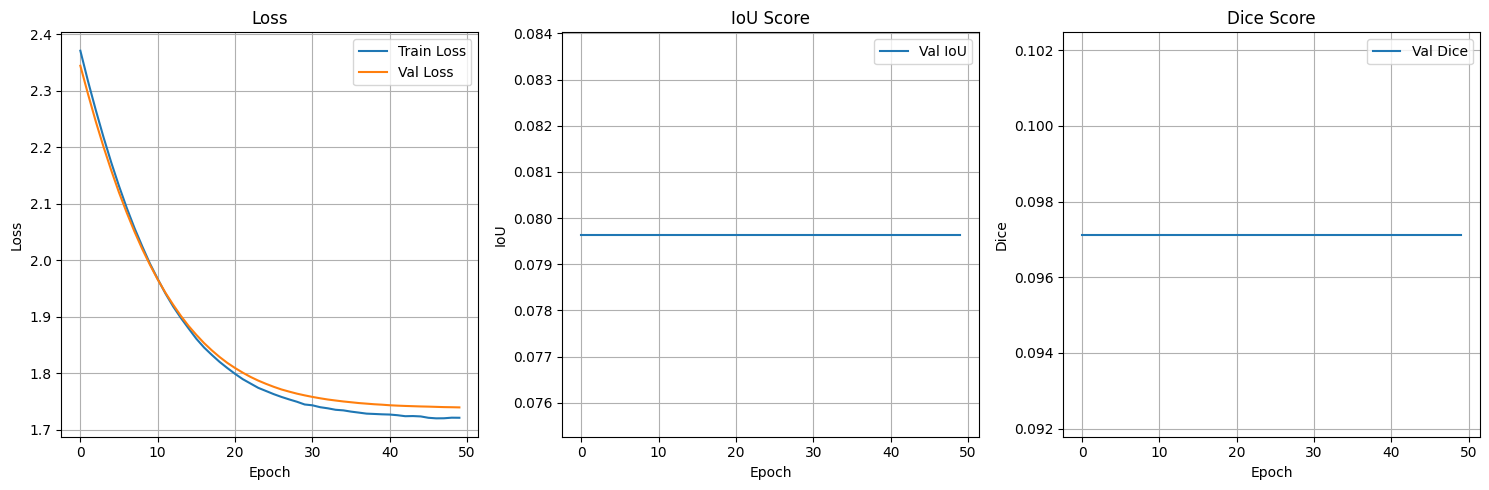

Best IoU: 0.0796
Final IoU: 0.0796
Best Dice: 0.0971
Final Dice: 0.0971


In [83]:
geoai.plot_performance_metrics(
    history_path=f"{model_folder}/unet_models/training_history.pth",
    figsize=(15, 5),
    verbose=True,
)